In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
DATAPATH = 'data/MSFT.csv'

In [4]:
data = pd.read_csv(DATAPATH, index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-11,140.119995,141.029999,139.500000,139.679993,138.107697,25446000
2019-10-14,139.690002,140.289993,139.520004,139.550003,137.979172,13304300
2019-10-15,140.059998,141.789993,139.809998,141.570007,139.976440,19695700
2019-10-16,140.789993,140.990005,139.529999,140.410004,138.829483,20751600
2019-10-17,140.949997,141.419998,139.020004,139.690002,138.117584,21460600
2019-10-18,139.759995,140.000000,136.559998,137.410004,135.863251,32273500
2019-10-21,138.449997,138.500000,137.009995,138.429993,136.871765,20078200
2019-10-22,138.970001,140.009995,136.259995,136.369995,134.834961,27431000
2019-10-23,136.880005,137.449997,135.610001,137.240005,135.695190,29844600


In [5]:
data.shape

(247, 6)

In [6]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
drop_cols = ['Adj Close', 'Volume']
data.drop(drop_cols, axis=1, inplace=True)

In [8]:
data.head()

,Open,High,Low,Close
Date,,,,
2019-10-11,140.119995,141.029999,139.500000,139.679993
2019-10-14,139.690002,140.289993,139.520004,139.550003
2019-10-15,140.059998,141.789993,139.809998,141.570007
2019-10-16,140.789993,140.990005,139.529999,140.410004
2019-10-17,140.949997,141.419998,139.020004,139.690002


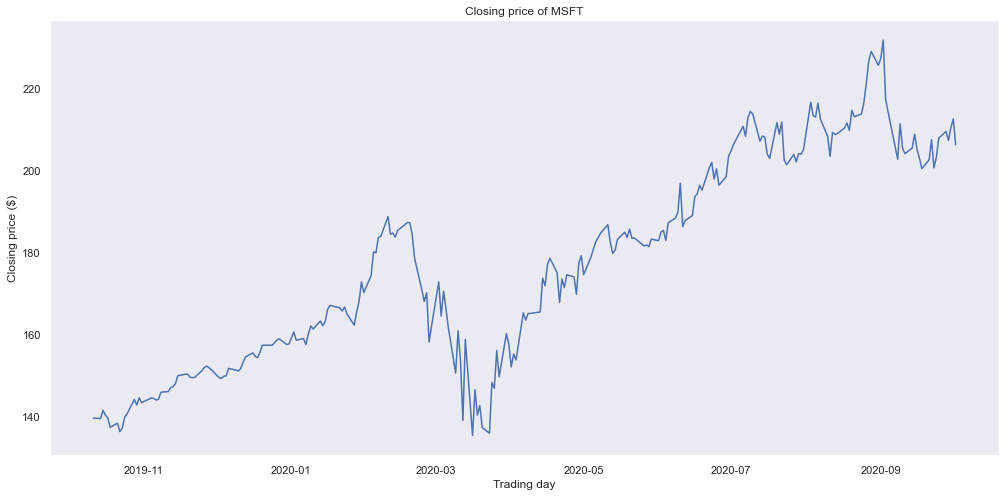

In [9]:
# Plot closing price
plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of MSFT')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [10]:
#Moving Average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

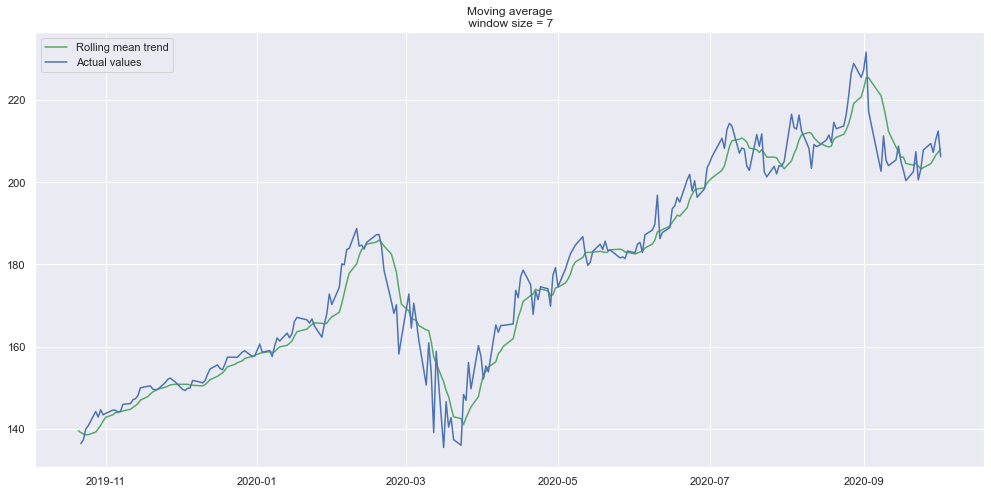

In [11]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 7)

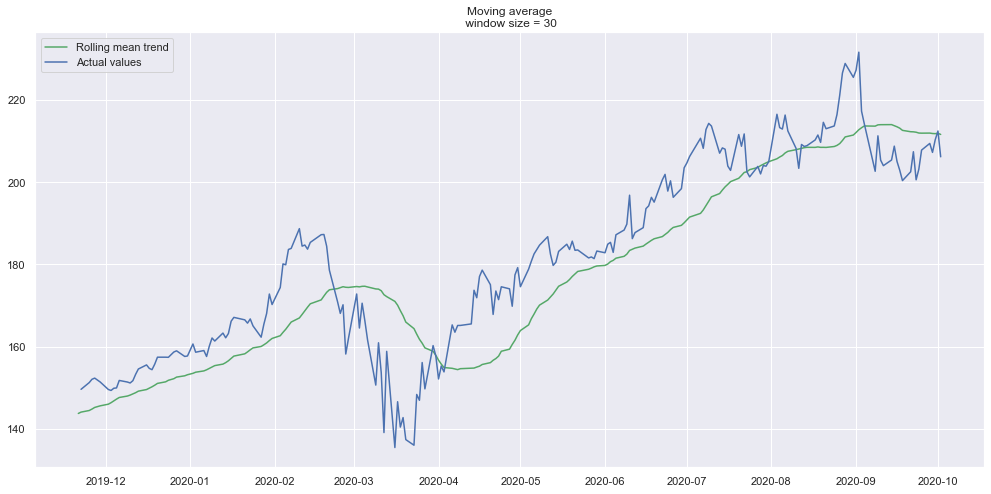

In [12]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

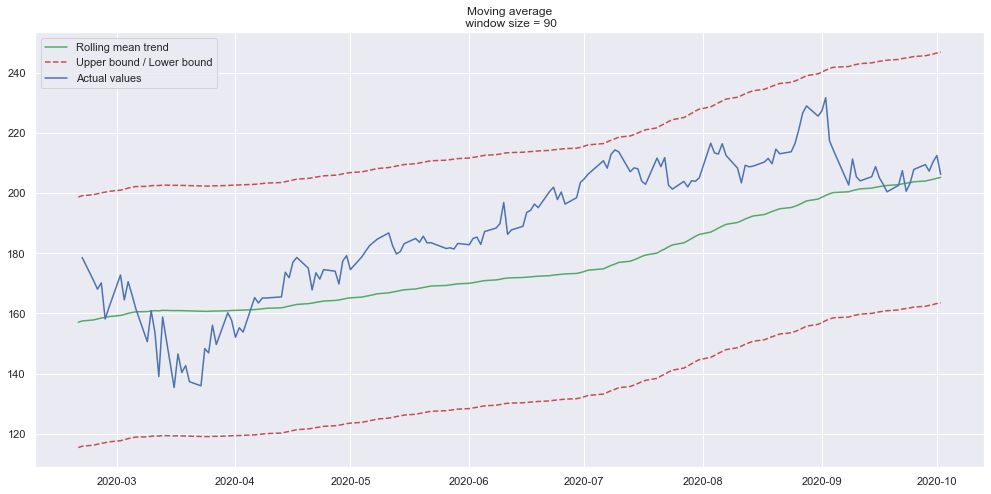

In [13]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

In [14]:
# Exponential smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [15]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

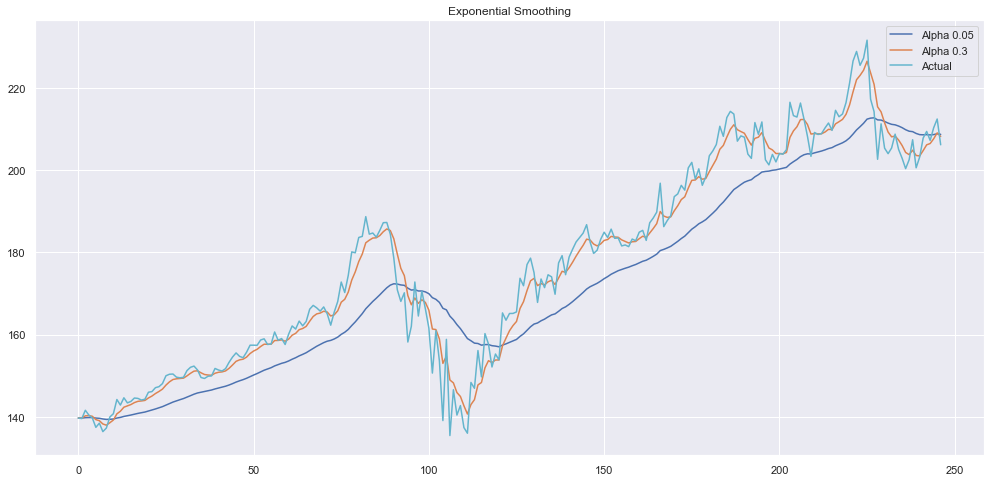

In [16]:
plot_exponential_smoothing(data.Close, [0.05, 0.3])

# As you can see, an alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

In [17]:
# Double exponential smoothing
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [18]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

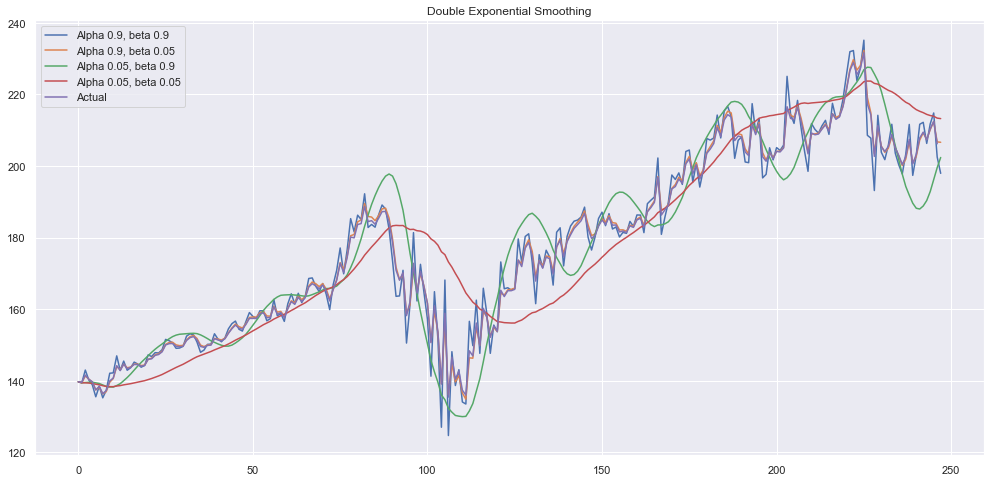

In [19]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.05], betas=[0.9, 0.05])

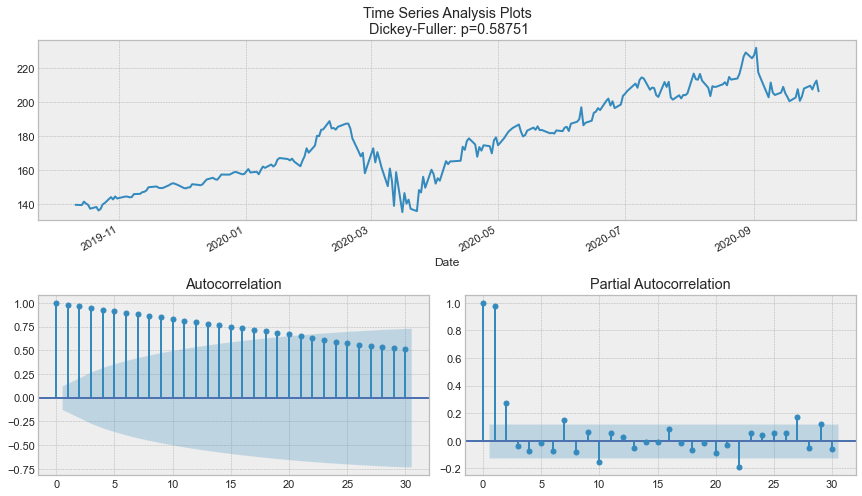

In [20]:
#Modelling
#As outlined previously, we must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process:

# Stationarity
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

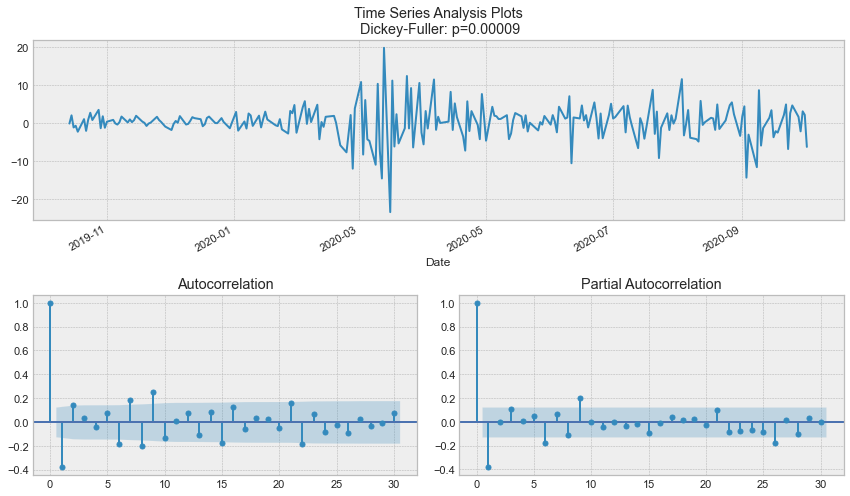

In [21]:
#By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.
#Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference (line 23 in the code block). We simply subtract the time series from itself with a lag of one day, and we get:

data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [22]:
#SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [23]:
## Train many SARIMA models to find the best set of parameters

def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [24]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  247
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 5)   Log Likelihood                -693.874
Date:                             Sun, 11 Oct 2020   AIC                           1399.748
Time:                                     23:52:47   BIC                           1420.657
Sample:                                          0   HQIC                          1408.172
                                             - 247                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9056      0.031    -29.217      0.000      -0.966      -0.845
ma.L1          0.5700      

In [26]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'Close': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.Close.shape[0], end=data.Close.shape[0] + 5))
print(mean_absolute_percentage_error(data.Close[s+d:], best_model.fittedvalues[s+d:]))

247    207.963165
248    209.259883
249    206.581430
250    209.833997
251    207.411544
252    209.889590
Name: predicted_mean, dtype: float64
1.6809165023844836


In [27]:
# Compare the predicted price to actual data
## Make a dataframe containing actual and predicted prices

comparison = pd.DataFrame({'actual': [210.38, 205.91, 209.83, 210.58, 215.81],
                          'predicted': [209.25, 206.58, 208.83, 207.41, 209.88]}, 
                          index = pd.date_range(start='2020-10-5', periods=5,))

In [28]:
comparison.head()

,actual,predicted
2020-10-05,210.38,209.25
2020-10-06,205.91,206.58
2020-10-07,209.83,208.83
2020-10-08,210.58,207.41
2020-10-09,215.81,209.88


No handles with labels found to put in legend.


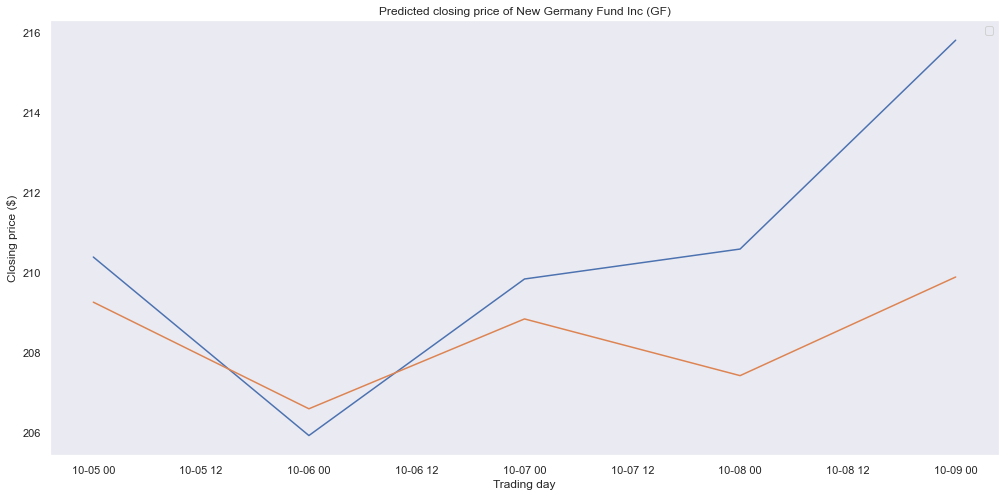

In [29]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()